# Kaggle Shelter Animal Outcomes

https://www.kaggle.com/c/shelter-animal-outcomes

The data comes from Austin Animal Center from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake. 

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

The train and test data are randomly split. 

# Data analysis

## Import common packages

In [82]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

## Load train and test datasets

In [83]:
train = pd.read_csv('train.csv.gz', parse_dates=['DateTime'], index_col='AnimalID')
test = pd.read_csv('test.csv.gz', parse_dates=['DateTime'], index_col='ID')

Lets take a look on train and test datasets

In [84]:
train.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [85]:
test.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
ID,,,,,,,
1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


## Train'n'Test proportion

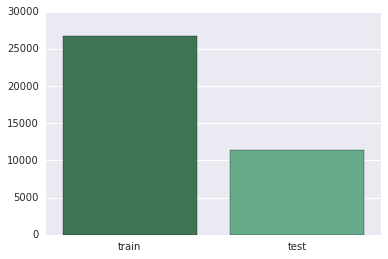

In [86]:
sns.barplot(x=['train', 'test'], y=[len(train), len(test)], palette="BuGn_d")

## Target distribution

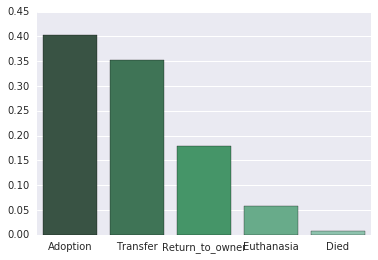

In [87]:
outcometype_dist = train['OutcomeType'].value_counts(normalize=True)
sns.barplot(x=outcometype_dist.index, y=outcometype_dist.values, palette="BuGn_d")

In [107]:
def factor_plot(data, x, hue):
    hue_dist = data[hue].value_counts()
    hue_frac_col = '{}_fraction'.format(hue)
    train[hue_frac_col] = train[hue].map(lambda v: 1/hue_dist[v])
    sns.factorplot(x=x, y=hue_frac_col, hue=hue, data=train, estimator=sum, kind='bar')
    data = data.drop(hue_frac_col, axis=1)

## OutcomeType and AnimalType correlation

### AnimalType distribution

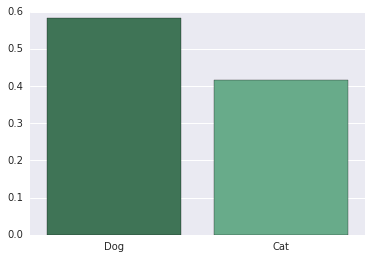

In [89]:
animaltype_dist = train['AnimalType'].value_counts(normalize=True)
sns.barplot(x=animaltype_dist.index, y=animaltype_dist.values, palette='BuGn_d')

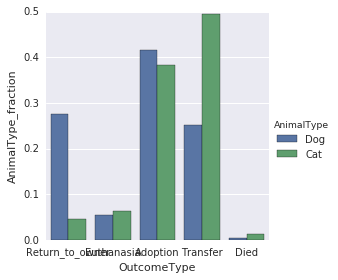

In [108]:
factor_plot(train, 'OutcomeType', 'AnimalType')

In [112]:
train['SexuponOutcome'] = train['SexuponOutcome'].fillna('Unknown')
def extract_sex(sex):
    if 'Female' in sex:
        return 'Female'
    if 'Male' in sex:
        return 'Male'
    return sex

train['Sex'] = train['SexuponOutcome'].map(extract_sex)

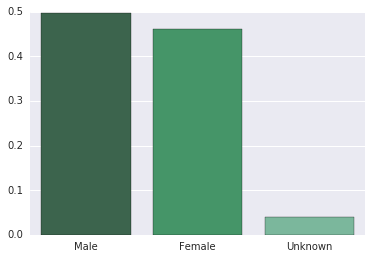

In [113]:
animaltype_dist = train['Sex'].value_counts(normalize=True)
sns.barplot(x=animaltype_dist.index, y=animaltype_dist.values, palette='BuGn_d')

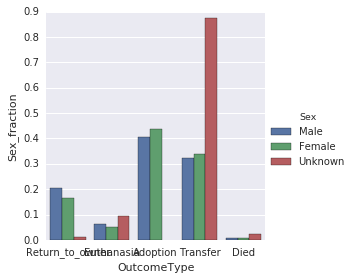

In [114]:
factor_plot(train, 'OutcomeType', 'Sex')

In [115]:
def extract_intact(sex):
    if 'Intact' in sex:
        return 'Intact'
    if 'Spayed' in sex or 'Neutered' in sex:
        return 'Spayed'
    return sex

train['Intact'] = train['SexuponOutcome'].map(extract_intact)

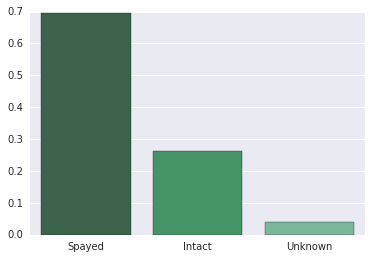

In [116]:
animaltype_dist = train['Intact'].value_counts(normalize=True)
sns.barplot(x=animaltype_dist.index, y=animaltype_dist.values, palette='BuGn_d')

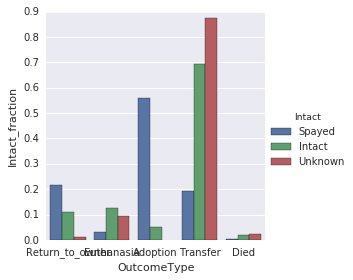

In [117]:
factor_plot(train, 'OutcomeType', 'Intact')

In [261]:
import re

def extract_age(age):
    if pd.isnull(age):
        return np.nan
    days_in = {
        'day': 1,
        'week': 7,
        'month': 30,
        'year': 365,
    }
    
    m = re.match('(?P<num>\d+)\s+(?P<period>\w+)', age)
    num = int(m.group('num'))
    period = m.group('period')
    if period.endswith('s'):
        period = period[:-1]
    return num * days_in[period]

train['Age'] = train['AgeuponOutcome'].map(extract_age)

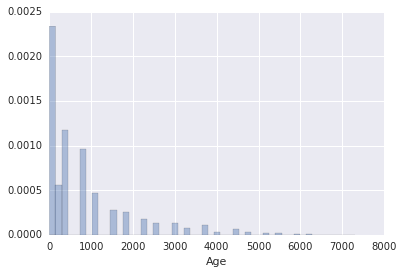

In [137]:
sns.distplot(train['Age'].dropna(), kde=False, norm_hist=True)

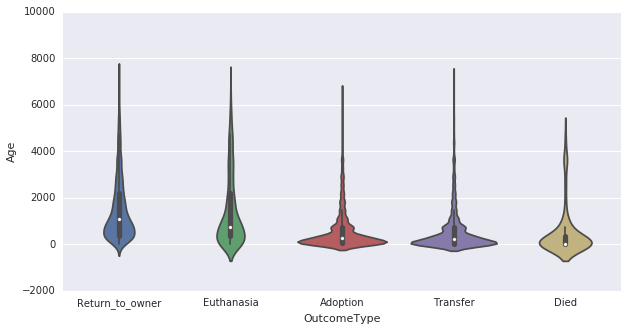

In [141]:
plt.figure(figsize=(10,5))
sns.violinplot(x='OutcomeType', y='Age', data=train)

In [159]:
train['Year'] = train['DateTime'].map(lambda dt: dt.year)
train['Quarter'] = train['DateTime'].map(lambda dt: dt.quarter)
train['Month'] = train['DateTime'].map(lambda dt: dt.month)
train['Day'] = train['DateTime'].map(lambda dt: dt.day)
train['DayOfWeek'] = train['DateTime'].map(lambda dt: dt.dayofweek)
train['Hour'] = train['DateTime'].map(lambda dt: dt.hour)

ERROR! Session/line number was not unique in database. History logging moved to new session 16


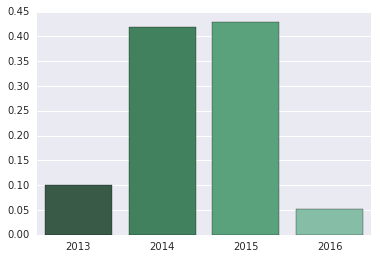

In [149]:
year_dist = train['Year'].value_counts(normalize=True)
sns.barplot(x=year_dist.index, y=year_dist.values, palette='BuGn_d')

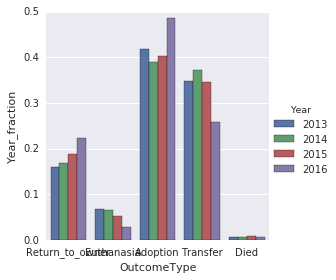

In [150]:
factor_plot(train, 'OutcomeType', 'Year')

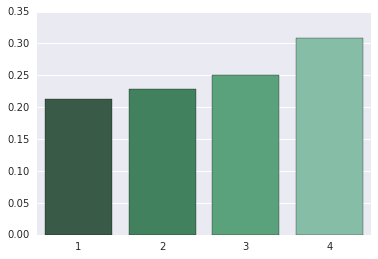

In [152]:
quarter_dist = train['Quarter'].value_counts(normalize=True)
sns.barplot(x=quarter_dist.index, y=quarter_dist.values, palette='BuGn_d')

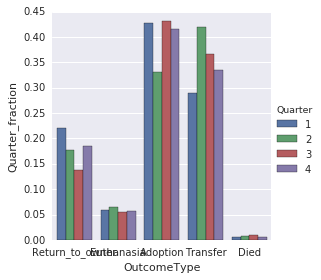

In [153]:
factor_plot(train, 'OutcomeType', 'Quarter')

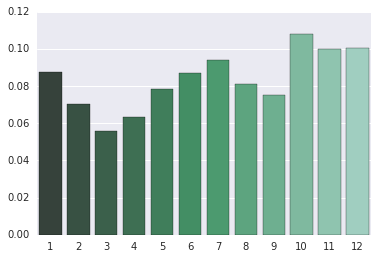

In [155]:
month_dist = train['Month'].value_counts(normalize=True)
sns.barplot(x=month_dist.index, y=month_dist.values, palette='BuGn_d')

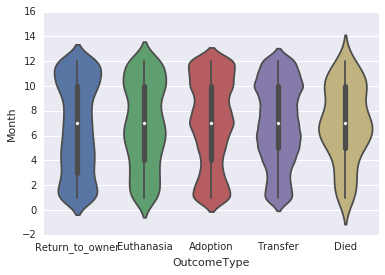

In [157]:
sns.violinplot(x='OutcomeType', y='Month', data=train)

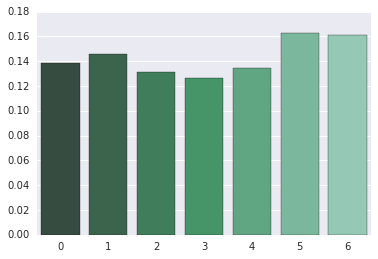

In [160]:
dayofweek_dist = train['DayOfWeek'].value_counts(normalize=True)
sns.barplot(x=dayofweek_dist.index, y=dayofweek_dist.values, palette='BuGn_d')

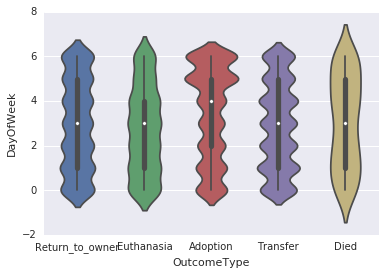

In [161]:
sns.violinplot(x='OutcomeType', y='DayOfWeek', data=train)

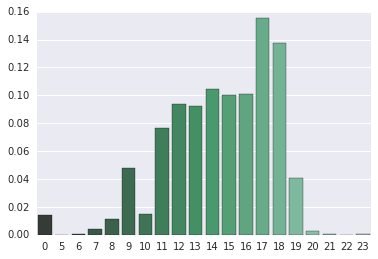

In [162]:
hour_dist = train['Hour'].value_counts(normalize=True)
sns.barplot(x=hour_dist.index, y=hour_dist.values, palette='BuGn_d')

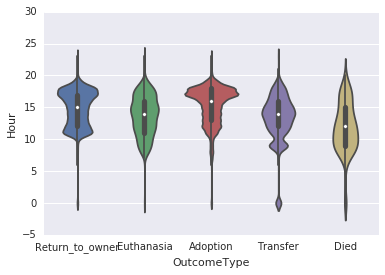

In [163]:
sns.violinplot(x='OutcomeType', y='Hour', data=train)

In [217]:
train['BreedMix'] = train['Breed'].map(lambda b: 'Mix' in b)
train['Longhair'] = train['Breed'].map(lambda b: 'Longhair' in b)
train['Shorthair'] = train['Breed'].map(lambda b: 'Shorthair' in b)

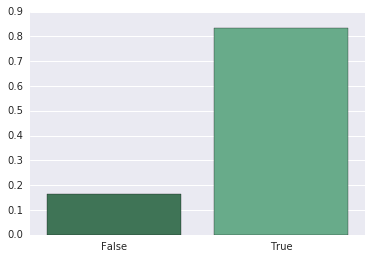

In [166]:
breed_mix_dist = train['BreedMix'].value_counts(normalize=True)
sns.barplot(x=breed_mix_dist.index, y=breed_mix_dist.values, palette='BuGn_d')

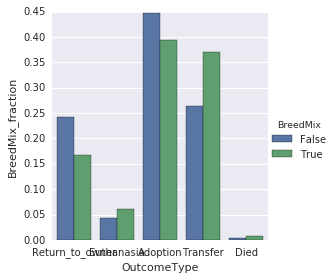

In [167]:
factor_plot(train, 'OutcomeType', 'BreedMix')

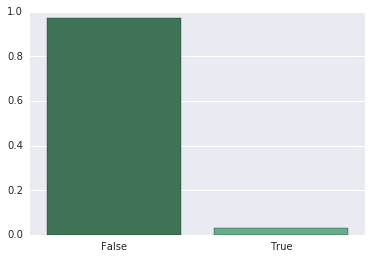

In [169]:
longhair_mix_dist = train['Longhair'].value_counts(normalize=True)
sns.barplot(x=longhair_mix_dist.index, y=longhair_mix_dist.values, palette='BuGn_d')

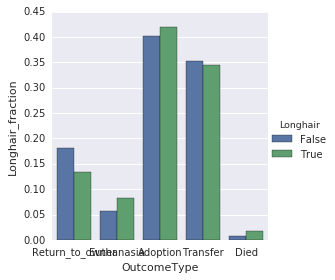

In [170]:
factor_plot(train, 'OutcomeType', 'Longhair')

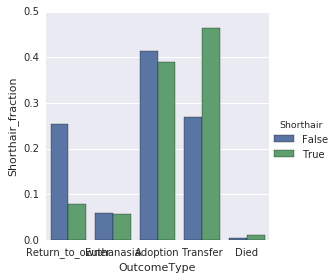

In [218]:
factor_plot(train, 'OutcomeType', 'Shorthair')

In [186]:
daysofweek = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
train[daysofweek] = pd.get_dummies(train['DayOfWeek'].map(lambda d: daysofweek[d]), columns=daysofweek)[daysofweek]

In [189]:
train['HasName'] = train['Name'].isnull().map(lambda t: not t)

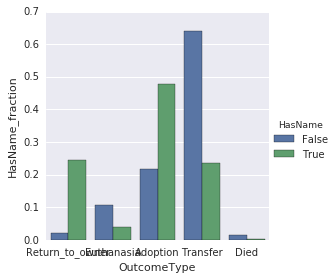

In [190]:
factor_plot(train, 'OutcomeType', 'HasName')

In [271]:
breeds_dist = train.append(test)['Breed'].value_counts(normalize=True)
train['BreedPopularity'] = train['Breed'].map(lambda b: breeds_dist[b])

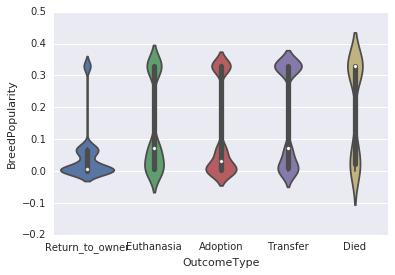

In [272]:
sns.violinplot(x='OutcomeType', y='BreedPopularity', data=train)

In [273]:
colors_dist = train.append(test)['Color'].value_counts(normalize=True)
train['ColorPopularity'] = train['Color'].map(lambda c: colors_dist[c])

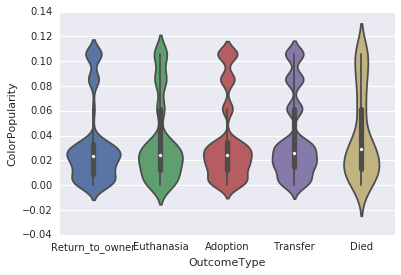

In [274]:
sns.violinplot(x='OutcomeType', y='ColorPopularity', data=train)

In [275]:
from sklearn.preprocessing import LabelEncoder

sex_encoder = LabelEncoder().fit(train['Sex'])
train['SexEncoded'] = sex_encoder.transform(train['Sex'])

intact_encoder = LabelEncoder().fit(train['Intact'])
train['IntactEncoded'] = intact_encoder.transform(train['Intact'])

animaltype_encoder = LabelEncoder().fit(train['AnimalType'])
train['AnimalTypeEncoded'] = animaltype_encoder.transform(train['AnimalType'])

outcometype_encoder = LabelEncoder().fit(train['OutcomeType'])
train['OutcomeTypeEncoded'] = outcometype_encoder.transform(train['OutcomeType'])

age_median = train['Age'].median()
train['AgeFilled'] = train['Age'].fillna(age_median)

In [276]:
features = [
    'AgeFilled',
    'AnimalTypeEncoded',
    'SexEncoded',
    'IntactEncoded',
    'HasName',
    'Year',
    'Month',
#     'Quarter',
    'Hour',
    'BreedMix',
    'BreedPopularity',
    'Longhair',
    'Shorthair',
#     'ColorPopularity',
    *daysofweek,
]

target = 'OutcomeTypeEncoded'

X = train[features]
y = train[target]

In [277]:
params = {
    'n_estimators': 100,
    'max_depth': 9,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'seed': 42,
}

In [278]:
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': np.arange(80, 120, 10),
    'max_depth': np.arange(8, 10),
}

grid_search = GridSearchCV(XGBClassifier(**params), param_grid, scoring='log_loss')

%time grid_search = grid_search.fit(X, y)

CPU times: user 6min 2s, sys: 27.2 s, total: 6min 29s
Wall time: 1min 3s


In [279]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 90}

In [280]:
grid_search.best_score_

-0.75145884424817977

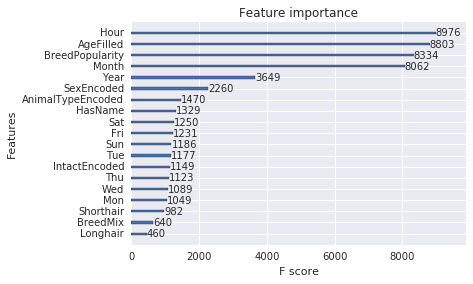

In [281]:
from xgboost import plot_importance
plot_importance(grid_search.best_estimator_)

In [282]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [283]:
from sklearn.metrics import log_loss

params1 = params.copy()
params1.update(grid_search.best_params_)
xgb = XGBClassifier(**params1).fit(X_train, y_train)
log_loss(y_test, xgb.predict_proba(X_test))

0.75046547891253668